# Indicators of Heart Disase (2022 Update)
`Data Set link: https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease`

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, classification_report, precision_score, recall_score

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference, true_positive_rate,false_positive_rate

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import numpy as np

In [22]:
df = pd.read_csv("heart_2020_cleaned.csv")
df_orginal = df.copy()

In [23]:
heart_2020_cleaned = pd.read_csv('heart_2020_cleaned.csv', sep = ',')
heart_2020_cleaned

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,Yes,27.41,Yes,No,No,7.0,0.0,Yes,Male,60-64,Hispanic,Yes,No,Fair,6.0,Yes,No,No
319791,No,29.84,Yes,No,No,0.0,0.0,No,Male,35-39,Hispanic,No,Yes,Very good,5.0,Yes,No,No
319792,No,24.24,No,No,No,0.0,0.0,No,Female,45-49,Hispanic,No,Yes,Good,6.0,No,No,No
319793,No,32.81,No,No,No,0.0,0.0,No,Female,25-29,Hispanic,No,No,Good,12.0,No,No,No


In [24]:
#DataFrame-Beispiel Daten
styled_df = df.head(10).style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#1f77b4'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tbody td', 'props': [('border', '1px solid #ddd'), ('text-align', 'center')]}
]).set_properties(**{'text-align': 'center'})

styled_df

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.600000,Yes,No,No,3.000000,30.000000,No,Female,55-59,White,Yes,Yes,Very good,5.000000,Yes,No,Yes
1,No,20.340000,No,No,Yes,0.000000,0.000000,No,Female,80 or older,White,No,Yes,Very good,7.000000,No,No,No
2,No,26.580000,Yes,No,No,20.000000,30.000000,No,Male,65-69,White,Yes,Yes,Fair,8.000000,Yes,No,No
3,No,24.210000,No,No,No,0.000000,0.000000,No,Female,75-79,White,No,No,Good,6.000000,No,No,Yes
4,No,23.710000,No,No,No,28.000000,0.000000,Yes,Female,40-44,White,No,Yes,Very good,8.000000,No,No,No
5,Yes,28.870000,Yes,No,No,6.000000,0.000000,Yes,Female,75-79,Black,No,No,Fair,12.000000,No,No,No
6,No,21.630000,No,No,No,15.000000,0.000000,No,Female,70-74,White,No,Yes,Fair,4.000000,Yes,No,Yes
7,No,31.640000,Yes,No,No,5.000000,0.000000,Yes,Female,80 or older,White,Yes,No,Good,9.000000,Yes,No,No
8,No,26.450000,No,No,No,0.000000,0.000000,No,Female,80 or older,White,"No, borderline diabetes",No,Fair,5.000000,No,Yes,No
9,No,40.690000,No,No,No,0.000000,0.000000,Yes,Male,65-69,White,No,Yes,Good,10.000000,No,No,No


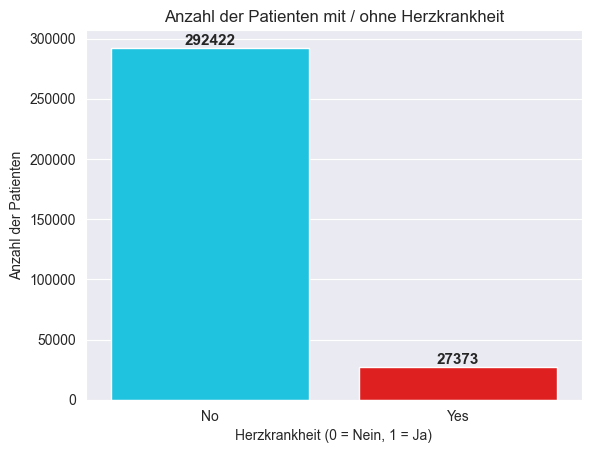

Anzahl der Zeilen (Patienten): 319795
Anzahl der Spalten (Features): 18


In [25]:
#Balkendiagramm Anteil Herzerkrankte

# Balkendiagramm OHNE FutureWarning
ax = sns.countplot(x='HeartDisease', hue='HeartDisease', data=df, palette=['#00d9ff', '#ff0000'], legend=False)


# Achsentitel
plt.title('Anzahl der Patienten mit / ohne Herzkrankheit')
plt.xlabel('Herzkrankheit (0 = Nein, 1 = Ja)')
plt.ylabel('Anzahl der Patienten')

# Zahlen über Balken schreiben
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom',
                fontsize=11, fontweight='bold')

# Plot anzeigen
plt.show()
print(f"Anzahl der Zeilen (Patienten): {df.shape[0]}")
print(f"Anzahl der Spalten (Features): {df.shape[1]}")

## Daten Vorverarbeitung

In [26]:
# Duplikate checken
# alle duplizierten Zeilen (inkl. Erstvorkommen)
duplikate_df = df[df.duplicated(keep=False)]

# Anzahl und Prozent Duplikate
anzahl_duplikate = len(duplikate_df)
gesamt = len(df)
prozent_duplikate = (anzahl_duplikate / gesamt) * 100

# Verteilung HeartDisease in den Duplikaten
verteilung_duplikate = duplikate_df['HeartDisease'].value_counts(normalize=True) * 100

# Verteilung HeartDisease im gesamten DataFrame
verteilung_gesamt = df['HeartDisease'].value_counts(normalize=True) * 100

# Ausgabe
print("Gesamtzeilen:", gesamt)
print("Anzahl mehrfach vorkommender Zeilen:", anzahl_duplikate)
print(f"Prozent mehrfach vorkommend: {prozent_duplikate:.2f}%\n")

print("Verteilung von Heartdisease innerhalb der Duplikate:")
if not verteilung_duplikate.empty:
    for wert, proz in verteilung_duplikate.items():
        print(f"  {wert}: {proz:.2f}%")
else:
    print("    - - -")

print("\nGesamtverteilung HeartDisease:")
for wert, proz in verteilung_gesamt.items():
    print(f"  {wert}: {proz:.2f}%")

Gesamtzeilen: 319795
Anzahl mehrfach vorkommender Zeilen: 29930
Prozent mehrfach vorkommend: 9.36%

Verteilung von Heartdisease innerhalb der Duplikate:
  No: 99.27%
  Yes: 0.73%

Gesamtverteilung HeartDisease:
  No: 91.44%
  Yes: 8.56%


In [27]:
# Duplikate entfernen
df = df.drop_duplicates()

In [28]:
# Fehlende Werte prüfen
print(df.isnull().sum())

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64


In [29]:
# Typprüfung
# also, ob wirklich die im Datensatz angegebenen Datentypen und beizeichnungen stimmen
def check_values(column_type, valid_values):
    if column_type not in df.columns:
        print(f"Spalte '{column_type}' nicht im Datensatz gefunden.")
        return

    values = df[column_type].dropna().unique()
    invalid = set(values).difference(set(valid_values))
    if invalid:
         print(f" Ungültige Werte in Spalte '{column_type}': {(invalid)} ")
    else:
        print(f"Alle Werte in Spalte '{column_type}' sind gültig ")

valid_values_dict = {
    "Sex": {'Male', 'Female'},
    "Smoking": {'Yes', 'No'},
    "AlcoholDrinking": {'Yes', 'No'},
    "Diabetic": {
        'Yes', 'No',
        'No, borderline diabetes',
        'Yes (during pregnancy)'
    },
    "GenHealth": {'Excellent', 'Very good', 'Good', 'Fair', 'Poor'},
    "Race": {
        'White', 'Black', 'Asian',
        'American Indian/Alaskan Native',
        'Other', 'Hispanic'
    },
    "AgeCategory": {
        '18-24', '25-29', '30-34', '35-39', '40-44', '45-49',
        '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80 or older'
    },
    "Asthma": {'Yes', 'No'},
    "KidneyDisease": {'Yes', 'No'},
    "SkinCancer": {'Yes', 'No'},
    "Stroke": {'Yes', 'No'},
    "DiffWalking": {'Yes', 'No'},
    "PhysicalActivity": {'Yes', 'No'},
    "HeartDisease": {'Yes', 'No'}
}


def check_if_numeric (column_type, valid_values):
    if column_type not in df.columns:
        print(f"Spalte {column_type}' nicht im Datensatz gefunden.")
        return
    else:
        non_numeric = df[column_type].dropna().apply(lambda x: not isinstance(x, (int, float)))
        if non_numeric.any():
            count_invalid = non_numeric.sum()
            print(f"{count_invalid} nicht numerische Werte in Spalte '{column_type}'")
            print(f"Beispiele: {df[column_type][non_numeric].unique()[:5]}")
        else:
            print(f"Alle Werte in Spalte '{column_type}' sind numerisch.")

numeric_columns = [
    'BMI',
    'PhysicalHealth',
    'MentalHealth',
    'SleepTime',
]


# Anwendung:
for column, valid_set in valid_values_dict.items():
    check_values(column, valid_set)

for col in numeric_columns:
    check_if_numeric(col, numeric_columns)

Alle Werte in Spalte 'Sex' sind gültig 
Alle Werte in Spalte 'Smoking' sind gültig 
Alle Werte in Spalte 'AlcoholDrinking' sind gültig 
Alle Werte in Spalte 'Diabetic' sind gültig 
Alle Werte in Spalte 'GenHealth' sind gültig 
Alle Werte in Spalte 'Race' sind gültig 
Alle Werte in Spalte 'AgeCategory' sind gültig 
Alle Werte in Spalte 'Asthma' sind gültig 
Alle Werte in Spalte 'KidneyDisease' sind gültig 
Alle Werte in Spalte 'SkinCancer' sind gültig 
Alle Werte in Spalte 'Stroke' sind gültig 
Alle Werte in Spalte 'DiffWalking' sind gültig 
Alle Werte in Spalte 'PhysicalActivity' sind gültig 
Alle Werte in Spalte 'HeartDisease' sind gültig 
Alle Werte in Spalte 'BMI' sind numerisch.
Alle Werte in Spalte 'PhysicalHealth' sind numerisch.
Alle Werte in Spalte 'MentalHealth' sind numerisch.
Alle Werte in Spalte 'SleepTime' sind numerisch.


In [30]:
print(f"Anzahl an Zeilen: {len(df)}")
# Unrealistische Werte
# aufgrund von medizinischen Hintergründen
def check_unrealistic_values(columnName, min_val, max_val):

    series = df[columnName]
    _df = df[(df[columnName] >= min_val) & (df[columnName] <= max_val)]

    invalid = series[(series < min_val) | (series > max_val)]
    print(f"{columnName}: {len(invalid)} Werte außerhalb des akzeptieren Bereichs '{min_val}-{max_val}'")
    #print(f"    Beispiele: {invalid.unique()[:5]}")
    return _df


df = check_unrealistic_values('BMI', 12, 70)
df = check_unrealistic_values('SleepTime', 2, 18)


print(f"Neue Anzahl an Zeilen: {len(df)}")

Anzahl an Zeilen: 301717
BMI: 129 Werte außerhalb des akzeptieren Bereichs '12-70'
SleepTime: 662 Werte außerhalb des akzeptieren Bereichs '2-18'
Neue Anzahl an Zeilen: 300926


Altersverteilung
count     300926
unique        13
top        65-69
freq       31598
Name: AgeCategory, dtype: object


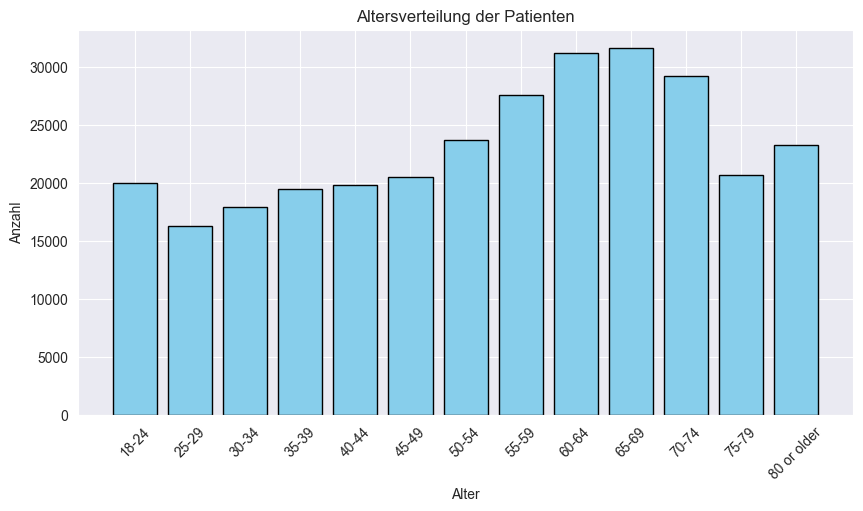

In [31]:
#Bias/Korrelation

print("Altersverteilung")
print(df['AgeCategory'].describe())

# Manuell definierte sinnvolle Reihenfolge
age_order = [
    '18-24', '25-29', '30-34', '35-39', '40-44',
    '45-49', '50-54', '55-59', '60-64', '65-69',
    '70-74', '75-79', '80 or older'
]

# Zählen und korrekt sortieren
age_counts = df['AgeCategory'].value_counts().reindex(age_order)

# Plot
plt.figure(figsize=(10,5))
plt.bar(age_counts.index, age_counts.values, color='skyblue', edgecolor='black')
plt.title('Altersverteilung der Patienten')
plt.xlabel('Alter')
plt.ylabel('Anzahl')
plt.xticks(rotation=45)
plt.show()

Geschlechterverteilung
Female: 159282 Patienten (52.93%)
Male: 141644 Patienten (47.07%)


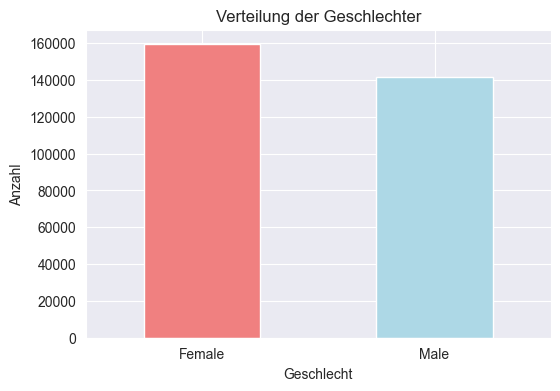

In [32]:

print("Geschlechterverteilung")
gender_counts = df['Sex'].value_counts()
gender_percent = df['Sex'].value_counts(normalize=True) * 100

for sex in gender_counts.index:
    print(f"{sex}: {gender_counts[sex]} Patienten ({gender_percent[sex]:.2f}%)")

plt.figure(figsize=(6,4))
gender_counts.plot(kind='bar', color=['lightcoral', 'lightblue'])
plt.title('Verteilung der Geschlechter')
plt.xlabel('Geschlecht')
plt.ylabel('Anzahl')
plt.xticks(rotation=0)
plt.show()


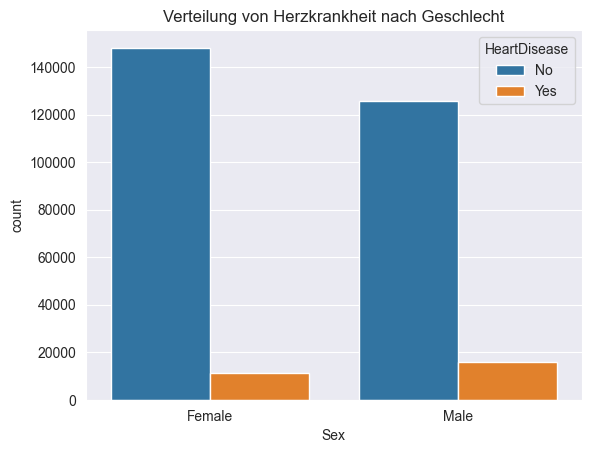

HeartDisease        No       Yes
Sex                             
Female        0.929885  0.070115
Male          0.887083  0.112917


In [33]:
# Bias: Zielverteilung nach Geschlecht
sns.countplot(data=df, x='Sex', hue='HeartDisease')
plt.title("Verteilung von Herzkrankheit nach Geschlecht")
plt.show()

# Diagnosewahrscheinlichkeit pro Geschlecht
print(df.groupby("Sex")["HeartDisease"].value_counts(normalize=True).unstack())


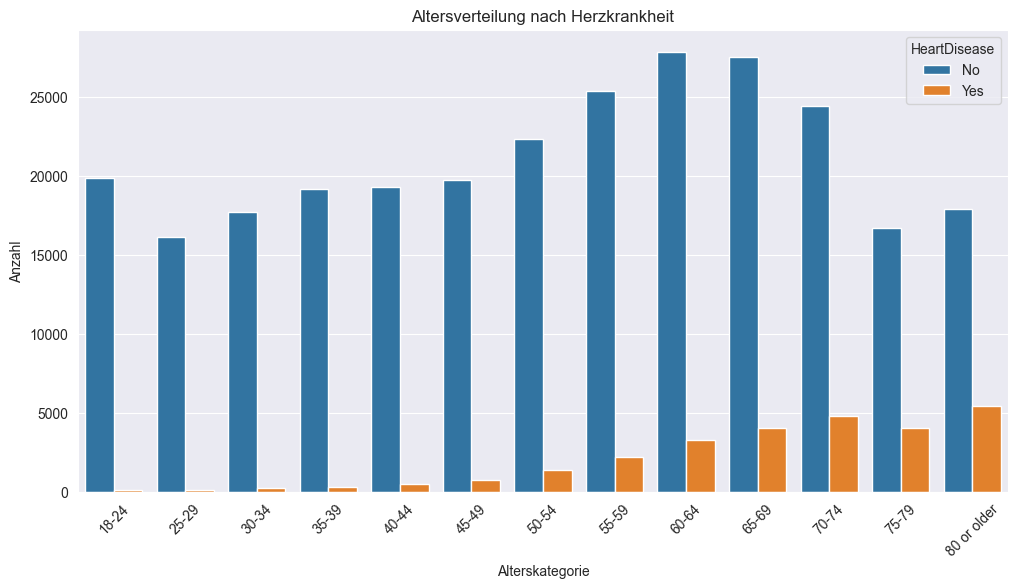

AgeCategory
18-24           0.63%
25-29           0.82%
30-34           1.25%
35-39           1.51%
40-44           2.45%
45-49           3.61%
50-54           5.81%
55-59           7.95%
60-64          10.62%
65-69          12.86%
70-74          16.45%
75-79          19.42%
80 or older    23.23%
Name: HeartDisease, dtype: object


In [34]:

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='AgeCategory', hue='HeartDisease', order=age_order)
plt.title("Altersverteilung nach Herzkrankheit")
plt.xlabel("Alterskategorie")
plt.ylabel("Anzahl")
plt.xticks(rotation=45)
plt.show()

# Anteil der 'Yes'-Werte pro Alterskategorie
heart_disease_by_age = df.groupby("AgeCategory")["HeartDisease"].apply(lambda x: (x == "Yes").mean())

# Optionale Ausgabe in Prozent:
print(heart_disease_by_age.apply(lambda x: f"{x*100:.2f}%"))


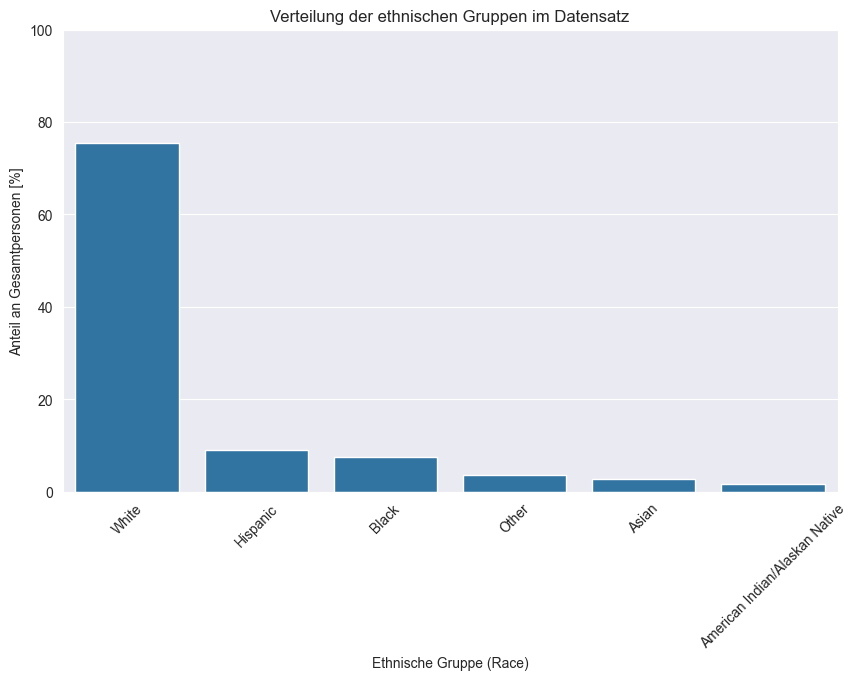

In [35]:
# Verteilung von Race
race_counts = df["Race"].value_counts(normalize=True) * 100

plt.figure(figsize=(10, 6))
sns.barplot(x=race_counts.index, y=race_counts.values)
plt.title("Verteilung der ethnischen Gruppen im Datensatz")
plt.xlabel("Ethnische Gruppe (Race)")
plt.ylabel("Anteil an Gesamtpersonen [%]")
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.show()

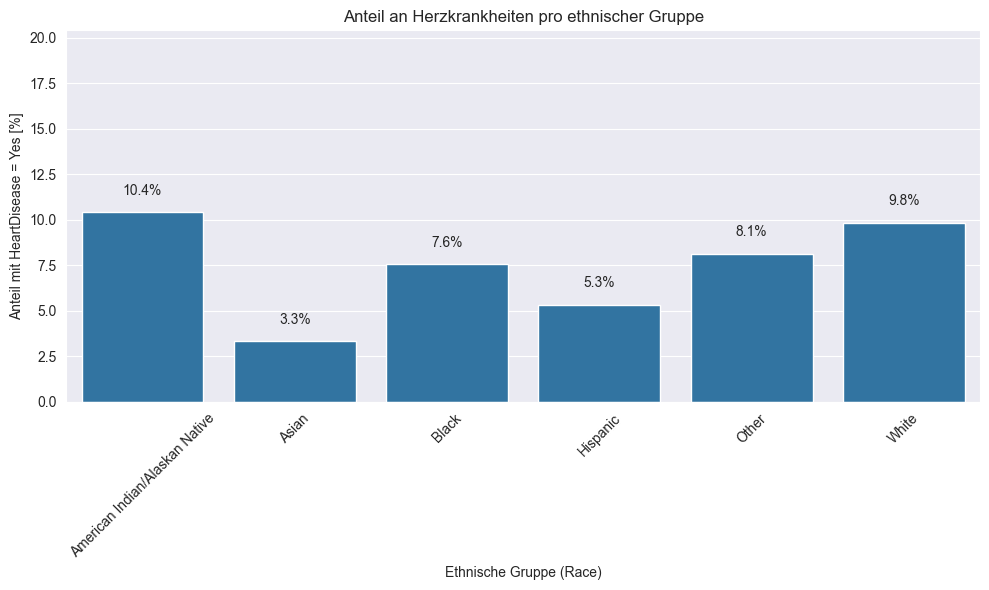

In [36]:

heart_disease_rates = df.groupby("Race")["HeartDisease"].apply(lambda x: (x == "Yes").mean()) * 100

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=heart_disease_rates.index, y=heart_disease_rates.values)

# Prozentzahlen über den Balken anzeigen
for i, value in enumerate(heart_disease_rates.values):
    ax.text(i, value + 0.8, f"{value:.1f}%", ha='center', va='bottom', fontsize=10)

plt.title("Anteil an Herzkrankheiten pro ethnischer Gruppe")
plt.xlabel("Ethnische Gruppe (Race)")
plt.ylabel("Anteil mit HeartDisease = Yes [%]")
plt.xticks(rotation=45)
plt.ylim(0, heart_disease_rates.max() + 10)
plt.tight_layout()
plt.show()

In [37]:
#binärisierung
binary_map = {"No": 0, "Yes": 1}
binary_columns = ["HeartDisease","Smoking", "AlcoholDrinking", "Stroke", "DiffWalking",
                  "PhysicalActivity", "Asthma", "KidneyDisease", "SkinCancer"]

for col in binary_columns:
    df[col] = df[col].map(binary_map)

df["Diabetic"] = df["Diabetic"].apply(lambda x: 0 if x == "No" else 1)


genhealth_map = {
        'Excellent': 4,
        'Very good': 3,
        'Good': 2,
        'Fair': 1,
        'Poor': 0
    }
df["GenHealth"] = df["GenHealth"].map(genhealth_map)
df["Sex"] = df["Sex"].map({"Female": 0, "Male": 1})

def age_to_mid(age):
        if "or older" in age:
            return 85
        low, high = map(int, age.split("-"))
        return (low + high) / 2

df["Age"] = df["AgeCategory"].apply(age_to_mid)
df.drop("AgeCategory", axis=1, inplace=True)

# Spalte 'race' löschen
df = df.drop(columns=['Race'])

In [38]:
# Skalierung
scaler = MinMaxScaler()
scale_cols = ["BMI", "PhysicalHealth", "MentalHealth", "SleepTime"]
df[scale_cols] = scaler.fit_transform(df[scale_cols])

In [39]:
styled_df_after = df.head(10).style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#1f77b4'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tbody td', 'props': [('border', '1px solid #ddd'), ('text-align', 'center')]}
]).set_properties(**{'text-align': 'center'})

styled_df_after

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,Age
0,0,0.079006,1,0,0,0.100000,1.000000,0,0,1,1,3,0.187500,1,0,1,57.000000
1,0,0.143523,0,0,1,0.000000,0.000000,0,0,0,1,3,0.312500,0,0,0,85.000000
2,0,0.251164,1,0,0,0.666667,1.000000,0,1,1,1,1,0.375000,1,0,0,67.000000
3,0,0.210281,0,0,0,0.000000,0.000000,0,0,0,0,2,0.250000,0,0,1,77.000000
4,0,0.201656,0,0,0,0.933333,0.000000,1,0,0,1,3,0.375000,0,0,0,42.000000
5,1,0.290668,1,0,0,0.200000,0.000000,1,0,0,0,1,0.625000,0,0,0,77.000000
6,0,0.165775,0,0,0,0.500000,0.000000,0,0,0,1,1,0.125000,1,0,1,72.000000
7,0,0.338451,1,0,0,0.166667,0.000000,1,0,1,0,2,0.437500,1,0,0,85.000000
8,0,0.248922,0,0,0,0.000000,0.000000,0,0,1,0,1,0.187500,0,1,0,85.000000
9,0,0.494566,0,0,0,0.000000,0.000000,1,1,0,1,2,0.500000,0,0,0,67.000000


## Machine Learning

In [40]:
#Train Test Split für RF, LR, Stacking

# 1. Daten vorbereiten: Heartdisease spalte und alte age Spalte entfernen
X = df.drop('HeartDisease', axis=1)
X = pd.get_dummies(X, drop_first=True)
y = df['HeartDisease']

# 2. Trainings-/Testdaten Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


### Logistische Regression

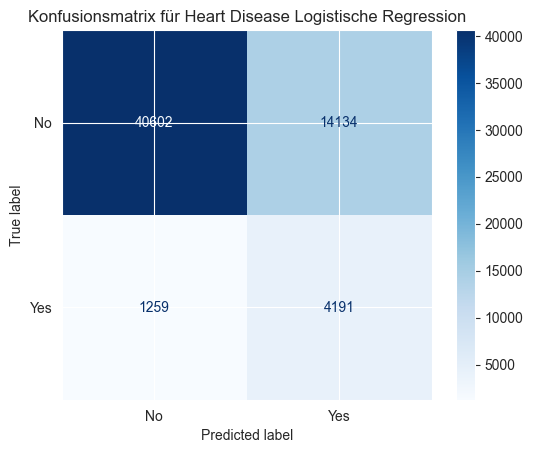

Genauigkeit: 0.7442428471737613
Fairness-Analyse nach 'Sex':
     accuracy  precision    recall  f1_score  selection_rate
Sex                                                         
0    0.789434   0.206284  0.686976  0.317292        0.237201
1    0.693617   0.244389  0.827316  0.377318        0.379835
Demographic Parity Difference: 0.143


In [41]:
#Logistische Regression
X = df.drop('HeartDisease', axis=1)
X = pd.get_dummies(X, drop_first=True)

y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

modelLogistic = LogisticRegression(max_iter=1000, class_weight='balanced')
modelLogistic.fit(X_train, y_train)

y_pred = modelLogistic.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease Logistische Regression')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
print("Genauigkeit:", accuracy)

# Wiederhole Vorhersagen
y_pred = modelLogistic.predict(X_test)

# Sensitives Merkmal extrahieren (Sex)
sensitive_feature = df.loc[X_test.index, "Sex"]  # 0 = Female, 1 = Male

# MetricFrame mit Gruppenvergleich
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}

frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_feature)

print("Fairness-Analyse nach 'Sex':")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")

Age: 0.0208 ± 0.0015
Sex: 0.0087 ± 0.0006
Stroke: 0.0051 ± 0.0002
GenHealth: 0.0014 ± 0.0008
KidneyDisease: 0.0013 ± 0.0004
MentalHealth: 0.0011 ± 0.0004
Asthma: 0.0009 ± 0.0003
PhysicalActivity: 0.0003 ± 0.0001
SleepTime: -0.0001 ± 0.0002
PhysicalHealth: -0.0002 ± 0.0002
AlcoholDrinking: -0.0002 ± 0.0002
SkinCancer: -0.0008 ± 0.0002
BMI: -0.0009 ± 0.0004
DiffWalking: -0.0009 ± 0.0003
Smoking: -0.0022 ± 0.0005
Diabetic: -0.0024 ± 0.0003


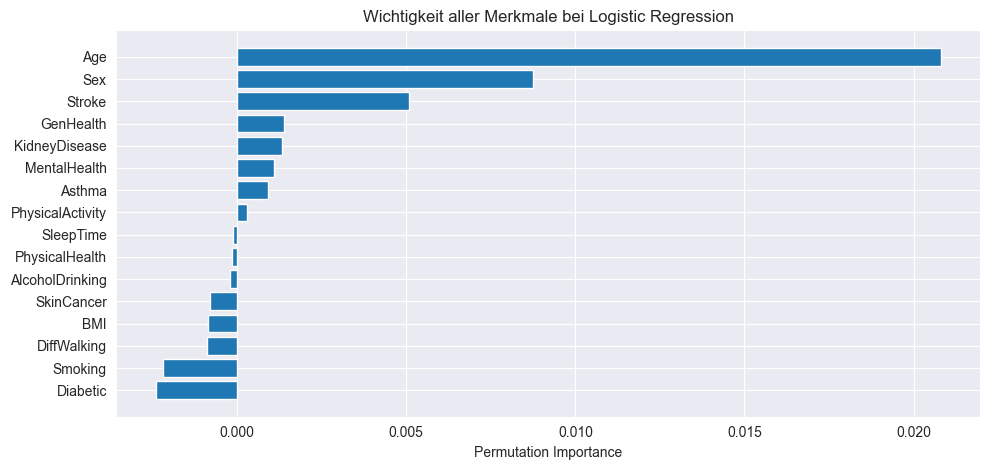

In [42]:
from sklearn.inspection import permutation_importance

# Permutation Importance berechnen
result = permutation_importance(modelLogistic, X_test, y_test, n_repeats=15, random_state=42, scoring='accuracy')

# Sortieren der Features nach ihrer Wichtigkeit (höchste zuerst)
sorted_idx = result.importances_mean.argsort()[::-1]

# Ausgabe aller Merkmale mit Mittelwert und Standardabweichung
for i in sorted_idx:
    print(f"{X_test.columns[i]}: {result.importances_mean[i]:.4f} ± {result.importances_std[i]:.4f}")

# Plot: Alle Merkmale anzeigen
plt.figure(figsize=(10, len(X_test.columns) * 0.3))  # Dynamische Höhe je nach Anzahl Features
plt.barh(X_test.columns[sorted_idx][::-1], result.importances_mean[sorted_idx][::-1])
plt.xlabel("Permutation Importance")
plt.title("Wichtigkeit aller Merkmale bei Logistic Regression")
plt.tight_layout()
plt.show()

### Random Forrest

In [ ]:
#Random Forest

# 3. Parametergrid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# 4. Random Forest mit GridSearchCV

rfc = RandomForestClassifier(random_state=42, class_weight='balanced')
grid_search = GridSearchCV(estimator=rfc,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)

# Trainingsdaten mit smote
grid_search.fit(X_train, y_train)
best_forest_model = grid_search.best_estimator_

#5. Bestes Modell anzeigen
print("Beste Parameterkombination:")
print(grid_search.best_params_)

# 6. Modell evaluieren
best_model = grid_search.best_estimator_
y_pred_rand = best_model.predict(X_test)

#7. Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_rand)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease Random Forest')
plt.show()

accuracy = accuracy_score(y_test, y_pred_rand)
print("Genauigkeit:", accuracy)

#8. Fairness-Analyse nach Geschlecht
# sensitives Merkmal extrahieren (Sex)
sensitive_feature = df.loc[X_test.index, "Sex"]  # 0 = Female, 1 = Male

# MetricFrame mit Gruppenvergleich
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}

frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_rand, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Sex':")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_rand, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")

Fitting 5 folds for each of 96 candidates, totalling 480 fits


In [ ]:

# Permutation Importance berechnen
result = permutation_importance(best_forest_model, X_test, y_test, n_repeats=15, random_state=42, scoring='accuracy')

# Sortieren der Features nach ihrer Wichtigkeit (höchste zuerst)
sorted_idx = result.importances_mean.argsort()[::-1]

# Ausgabe aller Merkmale mit Mittelwert und Standardabweichung
for i in sorted_idx:
    print(f"{X_test.columns[i]}: {result.importances_mean[i]:.4f} ± {result.importances_std[i]:.4f}")

# Plot: Alle Merkmale anzeigen
plt.figure(figsize=(10, len(X_test.columns) * 0.3))  # Dynamische Höhe je nach Anzahl Features
plt.barh(X_test.columns[sorted_idx][::-1], result.importances_mean[sorted_idx][::-1])
plt.xlabel("Permutation Importance")
plt.title("Wichtigkeit aller Merkmale bei Random Forest")
plt.tight_layout()
plt.show()


### Stacking mit logistischer Regression und Random Forrest als Base Model, und LR als Meta Modell

In [ ]:
#Stacking lr und rf als base model, lr als meta

# Basismodelle (schon trainiert mit SMOTE)
estimators = [
    ('rf', best_forest_model),
    ('lr', modelLogistic)
]

# Meta-Modell: Logistische Regression
final_estimator = LogisticRegression(max_iter=1000, class_weight='balanced')

# Stacking-Classifier
stacked_model = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    passthrough=False,  # wenn True werden auch Original-Features aus dem Meta-Modell übergeben
    n_jobs=-1
)

# Stacking-Modell (smote Trainingsdaten)
stacked_model.fit(X_train, y_train)

#  Vorhersage auf Testdaten
y_pred_stack = stacked_model.predict(X_test)


# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_stack)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease – Stacking-Modell')
plt.show()

accuracy = accuracy_score(y_test, y_pred_stack)
print("Genauigkeit (Stacking):", accuracy)

# Fairness-Analyse
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}
# nach Geschlecht
frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_stack, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Sex' (Stacking):")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_stack, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")

### Stacking mit logistischer Regression, Random Forrest und XG boost als Base Model, und LR als Meta Modell

In [77]:


# Basismodelle (lr und rf schon trainiert))
xgb_model = XGBClassifier(
    eval_metric='logloss',  # wichtig für Klassifikation
    random_state=42
)

estimators = [
    ('rf', best_forest_model),
    ('lr', modelLogistic),
    ('xgb', xgb_model)
]

# Meta-Modell: Logistische Regression
final_estimator = LogisticRegression(max_iter=1000, class_weight='balanced')

# Stacking-Classifier
stacked_model = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    passthrough=False,  # wenn True werden auch Original-Features aus dem Meta-Modell übergeben
    n_jobs=-1
)

# Stacking-Modell ()
stacked_model.fit(X_train, y_train)

#  Vorhersage auf Testdaten
y_pred_stack = stacked_model.predict(X_test)

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_stack)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease – Stacking-Modell')
plt.show()

accuracy = accuracy_score(y_test, y_pred_stack)
print("Genauigkeit (Stacking):", accuracy)

# Fairness-Analyse
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}
# nach Geschlecht
frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_stack, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Sex' (Stacking):")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_stack, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")

KeyboardInterrupt: 